Теория и текст взяты с этого источника: https://tproger.ru/articles/kejs-habib-vs-makgregor-ili-raspoznavanie-lic-na-python/

# Первичная настройка

Сначала скачиваем файл с готовой моделью с помощью команды wget и распаковываем файл в формат .dat

In [ ]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bunzip2 shape_predictor_68_face_landmarks.dat.bz2

--2021-04-22 21:05:50--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  17.8MB/s    in 3.8s    

2021-04-22 21:05:54 (16.3 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



In [ ]:
!pip install face_recognition

     |████████████████████████████████| 100.2MB 30kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566173 sha256=f3b314a2b466ba19fea586ef93a388e2570d7817f667780b2f6c7c86a649aa29
  Stored in directory: /root/.cache/pip/wheels/d2/99/18/59c6c8f01e39810415c0e63f5bede7d83dfb0ffc039865465f
Successfully built face-recognition-models


Далее создаем детектор лиц и передаем скачанную модель в shape_predictor, который будет предсказывать ключевые точки человеческого лица — контур головы, глаза, нос и рот.

In [ ]:
import dlib

face_detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

# Загрузка и обработка фотографий

Надо «прочитать» изображение в переменную Python. Это можно сделать несколькими способами, но нам удобнее представить изображение сразу в виде матрицы. Это можно сделать с помощью функции imread из модуля cv2.

Если вы загружаете цветную картинку, то «матрица» будет иметь размерность 3*height*width, где 3 — количество цветовых каналов (RGB), а width и height — размерность картинки в пикселях. Проверить это можно с помощью метода shape. Каждое число в матрице — значение пикселя по конкретному цветовому каналу.

In [ ]:
import cv2

img = cv2.imread('conor.jpg')
img.shape

(434, 770, 3)

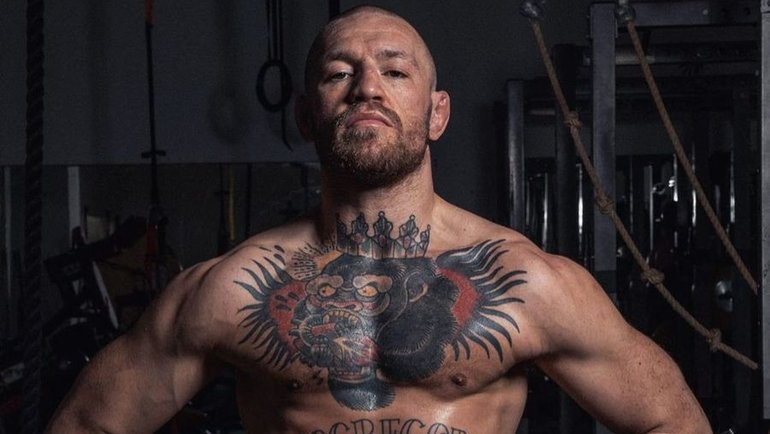

In [ ]:
from google.colab.patches import cv2_imshow

cv2_imshow(img)

В некоторых задачах имеет смысл обрабатывать не цветное изображение, а черно-белое. Например, на детекцию лиц наличие цвета мало влияет — контуры лица и так хорошо видны. А вот для нейронной сети это может быть принципиальный момент — мало ли, люди выглядят одинаково, а цвет кожи разный.

Поэтому давайте переведем нашу цветную картинку в черно-белую:

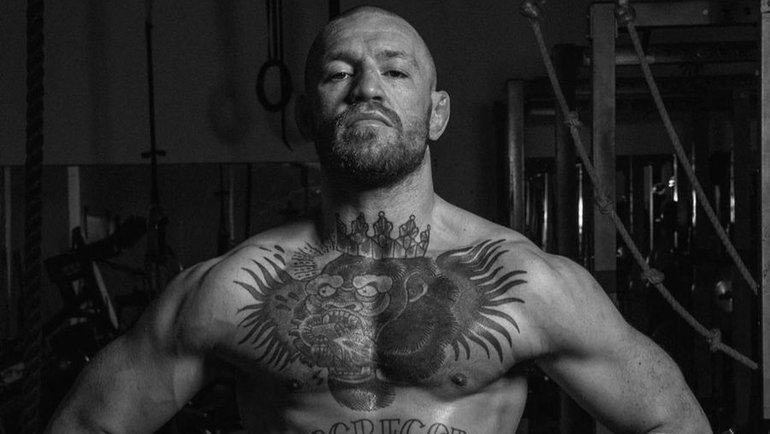

In [ ]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cv2_imshow(img)

# Детекция лица

Детектор лиц у нас уже настроен, поэтому можем переходить непосредственно к детекции. Делать это будем в 2 этапа:

Ищем прямоугольники, в которых находятся лица.
По этим прямоугольникам предсказываем контуры и ключевые точки лица.
С помощью detector мы получим координаты нужного прямоугольника. Если лиц несколько, то и наборов точек будет несколько. Чтобы выбрать конкретное лицо, нужно указать индекс (в нашем случае — ноль).

In [ ]:
face_rect = face_detector(img, 1)[0]

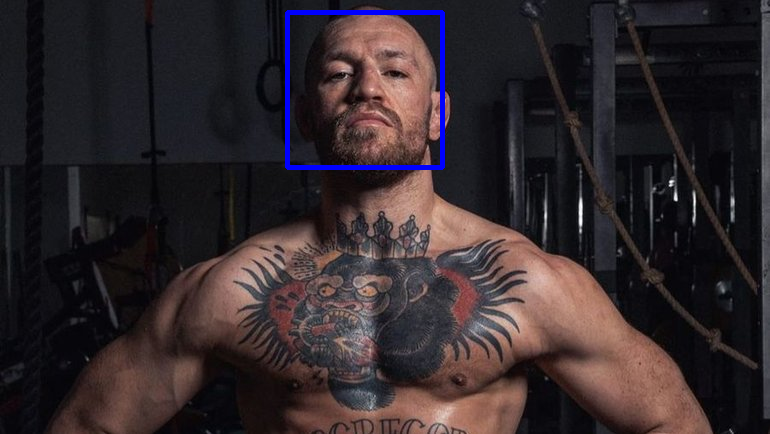

In [ ]:
# Blue color in BGR
color = (255, 0, 0)
# Line thickness of 2 px
thickness = 3

image = cv2.rectangle(img, (face_rect.left(), face_rect.top()), (face_rect.right(), face_rect.bottom()), color, thickness)
cv2_imshow(image)

Теперь по найденным квадратам нужно «предсказать» ключевые точки лица. Для этого используем predictor, а потом извлекаем координаты точек.

In [ ]:
import numpy as np

points = predictor(img, face_rect)
landmarks = np.array([*map(lambda p: [p.x, p.y], points.parts())])

# Обработка нейронной сетью

Основная идея обработки сетью заключается в том, что из исходного «большого» изображения выделяются только ключевые признаки, которые впоследствии и помогут нам отличить одного человека от другого. Другими словами, многомерная матрица-картинки преобразуется в относительно небольшой числовой вектор, который характеризует лицо с картинки.

Итак, получить итоговый вектор очень просто — достаточно вызвать функцию face_encodings.

In [ ]:
import face_recognition

vector = face_recognition.face_encodings(img)[0]

Обратите внимание, что в качестве аргументов мы передали только изображение, а полученные ранее ключевые точки мы не использовали. Причина очень проста — функция face_encodings делает все те же самые действия, которые мы с вами проделали вручную ранее для понимания процесса «изнутри».

На выходе мы получаем вектор размерности 128, т.е. 128 чисел, которые описывают лицо на фотографии. Что значит каждое из этих чисел — неизвестно: это некоторая абстракция, восстановить и осмыслить которую невозможно — слишком уж много математических преобразований лежит внутри этого процесса.

Однако, от этого вектора нам толку мало — чтобы оценить эффективность «нейросетевых технологий», нужно сравнить два вектора для двух разных фотографий. Давайте немного поэксперементируем — будем подавать разные фото на вход и сравнивать с нашим изначальным фото МакГрегора.

# Сравнение векторов

Чтобы сравнивать лица между собой, мы будем действовать следующим образом:

Загружаем новое фото и производим обработку, которую уже разобрали на предыдущих этапах. На выходе получаем вектор.
Сравниваем вектора между собой.
На основании расстояния принимаем решение — один и тот же человек на фото или разные.
Встает вопрос — что значит «сравнить вектора»? Самый простой способ — посчитать расстояние в некоторой метрике. Мы выберем обычную евклидову метрику. Вычислять ее без лишнего кода нам позволит функция pdist из scipy.spatial.distance.

Итак, сначала загрузим еще одну фотографию Конора.



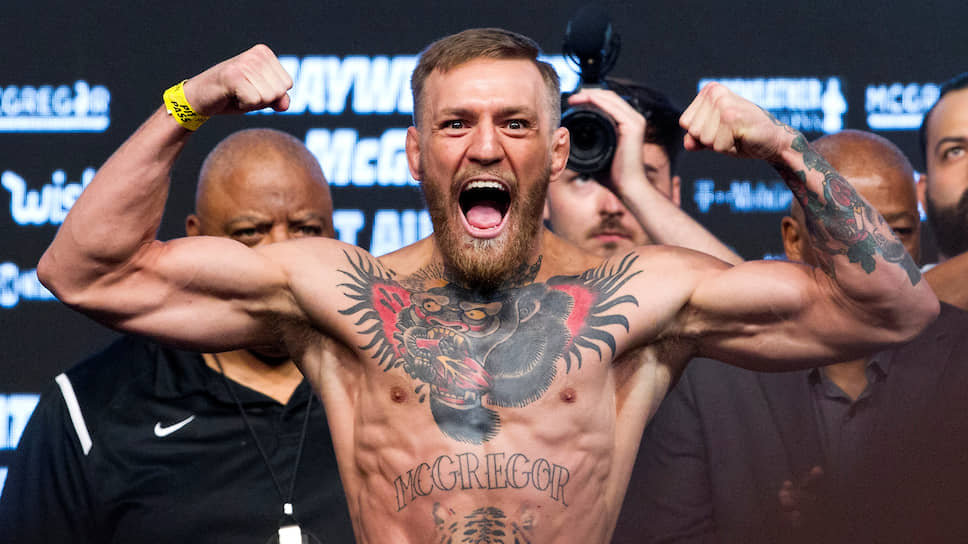

In [ ]:
img2 = cv2.imread('conor2.jpg')
cv2_imshow(img2)

In [ ]:
vector_test = face_recognition.face_encodings(img2)[0]

Сохраняем полученный вектор для первой фотографии в vector1, для второй — в vector2 и вычисляем расстояние:

In [ ]:
from scipy.spatial.distance import pdist

pdist([vector, vector_test], 'euclidean')

array([0.47565779])

Получаем ответ — 0,48. Это достаточно близкое расстояние, из чего делаем вывод, что это один и тот же человек. Сеть справилась отлично!

Ну хорошо, еще пару экспериментов — давайте возьмем снова Конора, но усложним задачу — пусть он будет в очках.

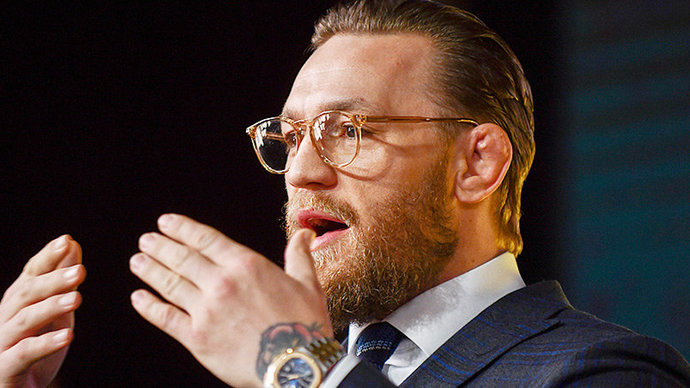

In [ ]:
img3 = cv2.imread('conor3.jpg')
cv2_imshow(img3)

In [ ]:
vector_test3 = face_recognition.face_encodings(img3)[0]

In [ ]:
pdist([vector, vector_test3], 'euclidean')

array([0.55698735])

Результат — 0,56. Снова в яблочко (разработчик библиотеки face_recognition рекомендует придерживаться порога 0,6 — если больше 0,6, то это другой человек).

Ну что ж, а может сеть просто всех определяет как Конора? Давайте подсунем ей другого бойца — Хабиба Нурмагомедова. Что наша сеть на это скажет?

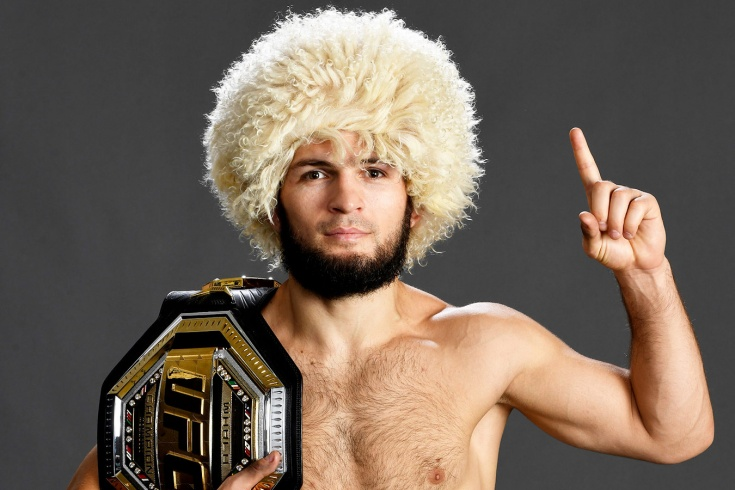

In [ ]:
img4 = cv2.imread('bib.jpg')
cv2_imshow(img4)

In [ ]:
vector_bib = face_recognition.face_encodings(img4)[0]

In [ ]:
pdist([vector, vector_bib], 'euclidean')

array([0.72229087])

Снова проводим уже известную процедуру и ответ… — 0.72. По утвержденному ранее порогу, делаем вывод: Хабиб — не Конор. Сеть снова нас не подвела, и мы со спокойной душой можем переходить к более сложным проектам.

# Эпилог
Мы с вами разобрали основной инструментарий, который вам понадобится для старта в области face recognition (да и в нейронных сетях, в целом). Однако это далеко не предел — мы затронули лишь верхушку айсберга, опустив очень много моментов как программных, так и математических.

Вот несколько вещей, которые мы рекомендуем вам сделать, чтобы прокачаться в области Computer Vision (компьютерное зрение):

Научитесь выстраивать процесс распознавания с нуля, без использования оберток (чем является библиотека face_recognition). Начните хотя бы с изучения исходников этой библиотеки на GitHub — там ничего сверхсложного нет.
Попробуйте разные нейронные сети. Погуглите state-of-the-art решения и посмотрите — чем будет различаться результат.
Изучите структуру нейронных сетей (например, сверточных) с математической точки зрения. Это можно сделать с помощью многочисленных туториалов и официальной документации библиотек (например, PyTorch).
Есть много и других точек роста, но начните с этих — остальные мысли придут в процессе 🙂

Статья для дальнейшего изучения темы: https://neurohive-io.turbopages.org/neurohive.io/s/ru/tutorial/raspoznavanie-lica-facenet/